In [1]:
import numpy as np
import pandas as pd 
import gc
import os
import time
import random

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

#from catboost import Pool, CatBoostRegressor
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SEED = 69
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Prepare data

In [3]:
class ASHRAE3Preprocessor(object):
       
    @classmethod
    def reduce_memory_usage(cls, df):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        for col in df.columns:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    

        return df
  
    @classmethod
    def timestamp_align(cls, weather_df):
        weather_key = ['site_id', 'timestamp']

        temp_skeleton = weather_df[weather_key + ['air_temperature']].sort_values(by=weather_key).copy()

        # calculate ranks of hourly temperatures within date/site_id chunks
        temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

        # create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
        df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

        # Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
        site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
        site_ids_offsets.index.name = 'site_id'
        
        weather_df['offset'] = weather_df.site_id.map(site_ids_offsets)
        weather_df['timestamp'] = (weather_df['timestamp'] - pd.to_timedelta(weather_df['offset'], unit='H'))
        
        del temp_skeleton, df_2d, site_ids_offsets
        
        return weather_df
        
    @classmethod
    def load_dataset(cls, df_path, weather_path, metadata_path):
        metadata = pd.read_csv(metadata_path)
        
        base_df = pd.read_csv(df_path, parse_dates=['timestamp'])
        merged_df = pd.merge(base_df, metadata, how="left", on=["building_id"])

        weather_df = pd.read_csv(weather_path, parse_dates=['timestamp'])
        weather_df = cls.timestamp_align(weather_df)
        
        df = pd.merge(merged_df, weather_df, how="left", on=["site_id", "timestamp"])
        
        del metadata, base_df, merged_df, weather_df
        
        # drop all NaN rows which are generated by timestamp alignment
        if(cls.train==True):
            df = df.loc[~(df['air_temperature'].isnull() & df['cloud_coverage'].isnull() & df['dew_temperature'].isnull() & df['precip_depth_1_hr'].isnull() & \
                          df['sea_level_pressure'].isnull() & df['wind_direction'].isnull() & df['wind_speed'].isnull() & df['offset'].isnull())]
            
            df = df.query('not (site_id == 0 & meter == 0 & timestamp <= "2016-05-20") and not (meter == 2 & building_id == 1099)')
        
        df['offset'] = np.uint8(df['offset'])
        
        return df
    
    @classmethod
    def fit(cls, df):
        data_ratios =  df.count()/len(df)
        cls.avgs = df.loc[:, data_ratios < 1.0].mean()
        cls.pu_le = LabelEncoder()
        cls.pu_le.fit(df["primary_use"])
     
    
    @classmethod
    def average_imputation(cls, df, column_name):
        imputation = df.groupby(['timestamp'])[column_name].mean()
    
        df.loc[df[column_name].isnull(), column_name] = df[df[column_name].isnull()][[column_name]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
        
        del imputation
        return df

    @classmethod
    def transform(cls, df):
        # refill NAN with averages
        columns_with_nan = cls.avgs.index.values
        for i in range(len(columns_with_nan)):
            df = cls.average_imputation(df, columns_with_nan[i])
        
        df['primary_use'] = np.uint8(cls.pu_le.transform(df['primary_use']))  # encode labels

        # expand datetime into its components
        df['hour'] = np.uint8(df['timestamp'].dt.hour)
        df['day'] = np.uint8(df['timestamp'].dt.day)
        df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
        df['dayofweek'] = np.uint8(df['timestamp'].dt.dayofweek)
        df['month'] = np.uint8(df['timestamp'].dt.month)
        df['year'] = np.uint8(df['timestamp'].dt.year-2000)
        
        # parse and cast columns to a smaller type
        df.rename(columns={"square_feet": "log_square_feet"}, inplace=True)
        df['log_square_feet'] = np.float16(np.log(df['log_square_feet']))
        df['year_built'] = np.uint8(df['year_built']-1900)
        df['floor_count'] = np.uint8(df['floor_count'])
        df['wind_direction'] = np.uint16(df['wind_direction'])
    
        # extract target column
        if 'meter_reading' in df.columns:
            df['meter_reading'] = np.log1p(df['meter_reading']).astype(np.float32) # comp metric uses log errors 
            
        return df
    
    @classmethod
    def add_features(cls, df):
        beaufort_boundaries = [0, 0.3, 1.6, 3.4, 5.5, 8, 10.8, 13.9, 17.2, 20.8, 24.5, 28.5, 33, 10000]
        df['wind_speed_beaufort_scale'] = pd.cut(
            x=df['wind_speed'], 
            bins=beaufort_boundaries, 
            labels=range(len(beaufort_boundaries)-1),
            right=False,
        ).cat.codes
        df['wind_speed_beaufort_scale'] = np.uint8(df['wind_speed_beaufort_scale'])
        
        #df.loc[(df['primary_use'] == le.transform(['Education'])[0]) & (df['month'] >= 6) & (df['month'] <= 8), 'is_vacation_month'] = np.int8(1)
        #df.loc[df['is_vacation_month']!=1, 'is_vacation_month'] = np.int8(0)
        
        df['group'] = df['month']
        df['group'].replace((6, 7, 8), 21, inplace=True)
        df['group'].replace((9, 10, 11), 22, inplace=True)
        df['group'].replace((3, 4, 5), 23, inplace=True)
        df['group'].replace((1, 2, 12), 24, inplace=True)
        df['group'].replace((21), 1, inplace=True)
        df['group'].replace((22), 2, inplace=True)
        df['group'].replace((23), 3, inplace=True)
        df['group'].replace((24), 4, inplace=True)
        df['group'] = np.uint8(df['group'])
        
        
        # remove redundant columns
        for col in df.columns:
            if col in ['timestamp', 'row_id']:
                del df[col]
        
        return df
    
    @classmethod
    def get_prepared_dataset(cls, df_path, weather_path, metadata, train):
        cls.train = train
        
        df = cls.load_dataset(df_path, weather_path, metadata)
        
        start_mem = df.memory_usage().sum() / 1024**2 
      
        df = cls.reduce_memory_usage(df)
        
        end_mem = df.memory_usage().sum() / 1024**2
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem)) 
        
        cls.fit(df)
        df = cls.transform(df)
        df = cls.add_features(df)

        return df

In [7]:
train_path = "./data/train.csv"
test_path = "./data/test.csv"

train_weather_path = "./data/weather_train.csv"
test_weather_path = "./data/weather_test.csv"

metadata_path = './data/building_metadata.csv'

In [8]:
def load_dataset(df_path, df_weather_path, metadata_path, train):
    return ASHRAE3Preprocessor.get_prepared_dataset(df_path, df_weather_path, metadata_path, train)

In [9]:
train_df = load_dataset(train_path, train_weather_path, metadata_path, train =True)
gc.collect()

test_df = load_dataset(test_path, test_weather_path, metadata_path, train =False)
gc.collect()

Executed


C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mem. usage decreased to 1036.33 Mb (59.9% reduction)


C:\Program Files\Python36\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Mem. usage decreased to 2187.13 Mb (59.9% reduction)


98

# Build Model

In [10]:
def RMSLE(y_true, y_pred, *args, **kwargs):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [11]:
categoricals = ["site_id", "building_id", "primary_use", "hour", "weekday", 'dayofweek', "meter", "wind_direction", 'group']

In [12]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.4,
            'learning_rate': 0.15,
            'num_leaves': 40,
            'feature_fraction': 0.4,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

In [17]:
skf = GroupKFold(n_splits=4)
oof = train_df[['meter_reading']]
oof['predict'] = 0
predictions =  pd.DataFrame()
val_rmsle = []
feature_importance_df = pd.DataFrame()

features = [col for col in train_df.columns if col not in ['meter_reading', 'year', 'month', 'day', 'timestamp']]

C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
models = []

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['meter_reading'], groups=train_df['group'])):
    gc.collect()
    
    X_train, y_train = train_df[features].iloc[trn_idx], train_df['meter_reading'].iloc[trn_idx]
    X_valid, y_valid = train_df[features].iloc[val_idx], train_df['meter_reading'].iloc[val_idx]

    start = time.strftime("%H:%M:%S")
    print(f"Starting for a fold: {fold} | ⏰: {start}")
    
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categoricals)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=10000,
                    valid_sets=(lgb_eval),
                    early_stopping_rounds=500,
                    verbose_eval = 500,
                    categorical_feature=categoricals)

    predicting_started = time.strftime("%H:%M:%S")
    print(f"Predicting for a fold: {fold} | started at | ⏰: {predicting_started}")
    
    predictions['group{}'.format(fold+1)] = np.expm1(gbm.predict(test_df[features]))
    
    val_pred = gbm.predict(X_valid)
    oof['predict'].iloc[val_idx] = val_pred
    oof['meter_reading'].iloc[val_idx] = y_valid
    
    val_pred = np.array(val_pred).clip(min=0)
    val_score = RMSLE(y_valid, val_pred)
    val_rmsle.append(val_score)
    
    print(f"RMSE: {val_score}")

    models.append(gbm)   
    
    feature_importance_extraction_started = time.strftime("%H:%M:%S")
    print(f"Feature importance extraction a fold: {fold} | started at | ⏰: {feature_importance_extraction_started}")
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = gbm.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Starting for a fold: 0 | ⏰: 19:04:20
Train until valid scores didn't improve in 500 rounds.
[500]	valid_0's rmse: 1.17517
[1000]	valid_0's rmse: 1.13656
[1500]	valid_0's rmse: 1.1271
[2000]	valid_0's rmse: 1.12061
[2500]	valid_0's rmse: 1.11544
[3000]	valid_0's rmse: 1.10962
[3500]	valid_0's rmse: 1.10527
[4000]	valid_0's rmse: 1.10403
[4500]	valid_0's rmse: 1.10223
[5000]	valid_0's rmse: 1.10085
[5500]	valid_0's rmse: 1.09994
[6000]	valid_0's rmse: 1.09902
[6500]	valid_0's rmse: 1.09843
[7000]	valid_0's rmse: 1.09754
[7500]	valid_0's rmse: 1.09737
[8000]	valid_0's rmse: 1.09648
[8500]	valid_0's rmse: 1.09497
[9000]	valid_0's rmse: 1.0971
Early stopping, best iteration is:
[8527]	valid_0's rmse: 1.09494
Predicting for a fold: 0 | started at | ⏰: 19:55:40


C:\Program Files\Python36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE: 0.360841263972963
Feature importance extraction a fold: 0 | started at | ⏰: 22:24:42
Starting for a fold: 1 | ⏰: 22:24:58
Train until valid scores didn't improve in 500 rounds.
[500]	valid_0's rmse: 1.15765
[1000]	valid_0's rmse: 1.10643
[1500]	valid_0's rmse: 1.08213
[2000]	valid_0's rmse: 1.06667
[2500]	valid_0's rmse: 1.0596
[3000]	valid_0's rmse: 1.05729
Early stopping, best iteration is:
[2798]	valid_0's rmse: 1.05472
Predicting for a fold: 1 | started at | ⏰: 22:37:21


C:\Program Files\Python36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE: 0.3482465389516195
Feature importance extraction a fold: 1 | started at | ⏰: 22:59:49
Starting for a fold: 2 | ⏰: 22:59:57
Train until valid scores didn't improve in 500 rounds.
[500]	valid_0's rmse: 1.10256
[1000]	valid_0's rmse: 1.05935
[1500]	valid_0's rmse: 1.04343
[2000]	valid_0's rmse: 1.03266
[2500]	valid_0's rmse: 1.02521
[3000]	valid_0's rmse: 1.0181
[3500]	valid_0's rmse: 1.01563
[4000]	valid_0's rmse: 1.01391
[4500]	valid_0's rmse: 1.01351
[5000]	valid_0's rmse: 1.01074
[5500]	valid_0's rmse: 1.0096
Early stopping, best iteration is:
[5479]	valid_0's rmse: 1.009
Predicting for a fold: 2 | started at | ⏰: 23:22:08


C:\Program Files\Python36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE: 0.3319718750593103
Feature importance extraction a fold: 2 | started at | ⏰: 00:22:32
Starting for a fold: 3 | ⏰: 00:22:43
Train until valid scores didn't improve in 500 rounds.
[500]	valid_0's rmse: 1.10377
[1000]	valid_0's rmse: 1.05617
[1500]	valid_0's rmse: 1.03768
[2000]	valid_0's rmse: 1.02741
[2500]	valid_0's rmse: 1.02288
[3000]	valid_0's rmse: 1.01498
[3500]	valid_0's rmse: 1.01113
[4000]	valid_0's rmse: 1.00783
[4500]	valid_0's rmse: 1.00563
[5000]	valid_0's rmse: 1.00394
[5500]	valid_0's rmse: 1.00254
[6000]	valid_0's rmse: 1.00121
[6500]	valid_0's rmse: 1.00107
[7000]	valid_0's rmse: 1.00033
[7500]	valid_0's rmse: 1.00014
Early stopping, best iteration is:
[7159]	valid_0's rmse: 0.999981
Predicting for a fold: 3 | started at | ⏰: 00:49:48


C:\Program Files\Python36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE: 0.3273321508516979
Feature importance extraction a fold: 3 | started at | ⏰: 02:24:19


In [20]:
oof['predict'][oof['predict'] < 0] = 0
mean_rmsle = np.mean(val_rmsle)
std_rmsle = np.std(val_rmsle)
all_rmsle = RMSLE(oof['meter_reading'], oof['predict'])
print("Mean rmse: %.9f, std: %.9f. All auc: %.9f." % (mean_rmsle, std_rmsle, all_rmsle))

C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Program Files\Python36\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Program Files\Python36\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

Mean rmse: 0.342097957, std: 0.013319940. All auc: 0.342807762.


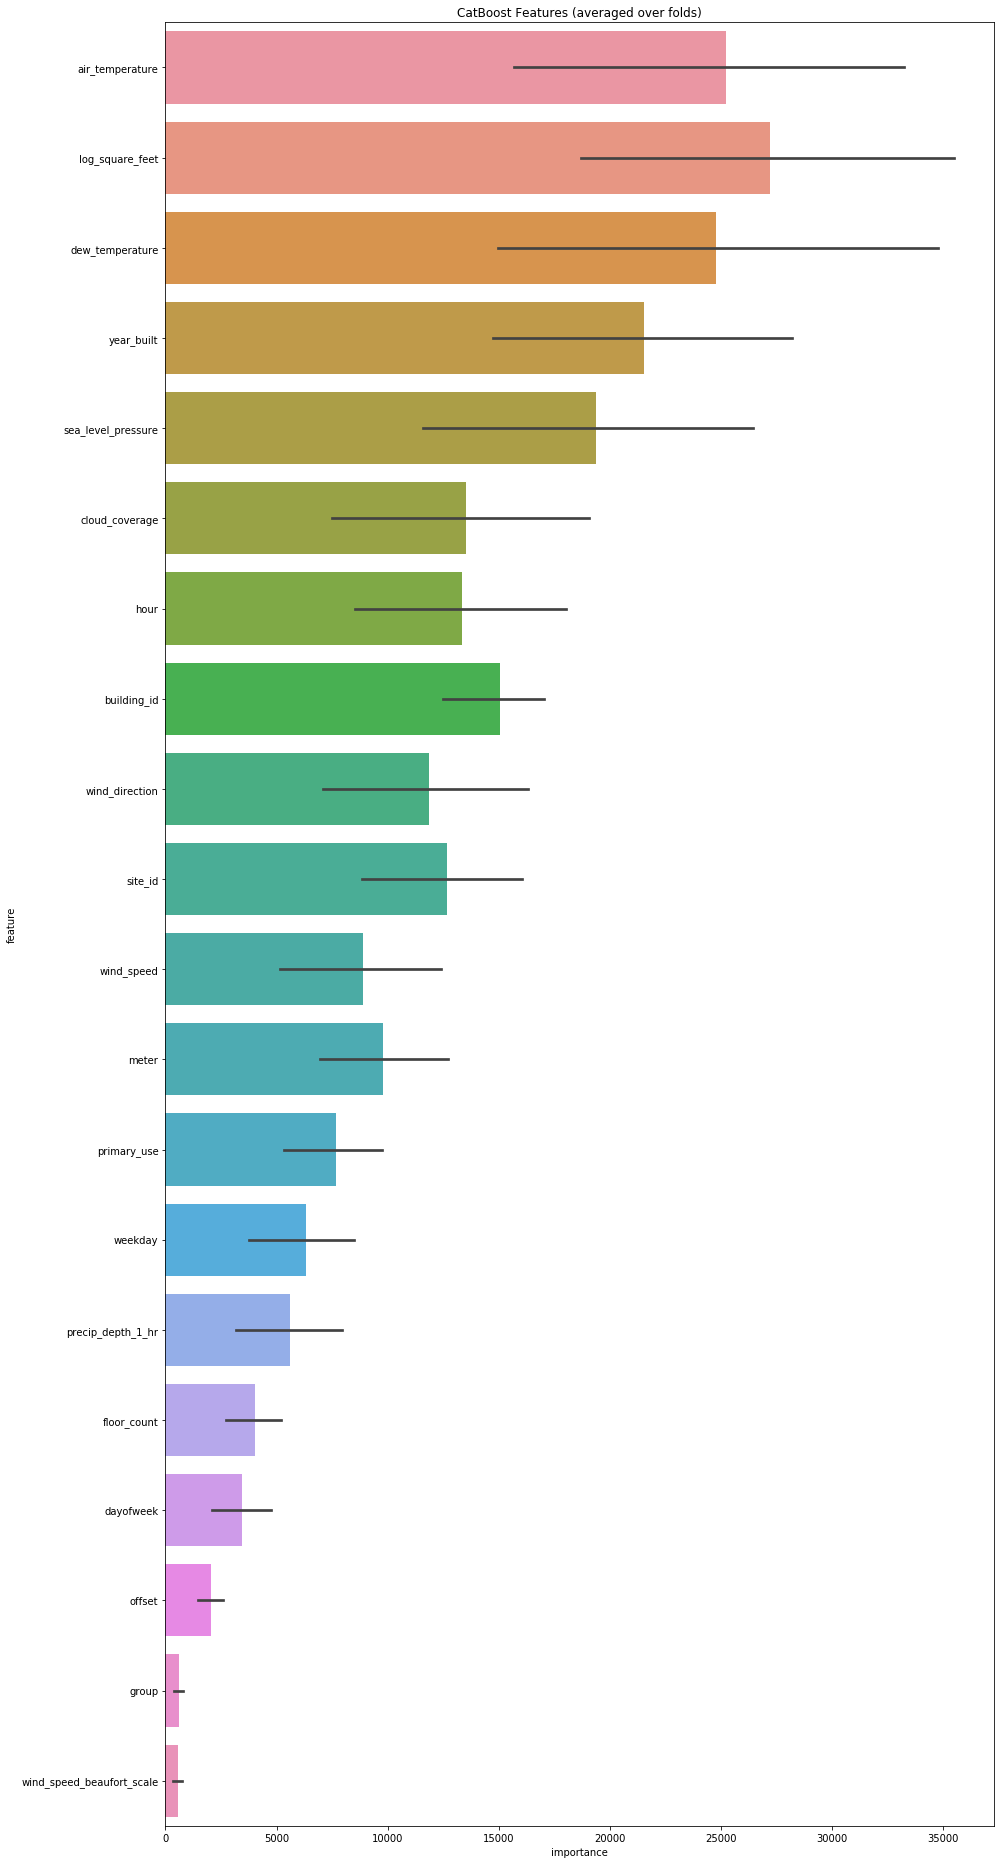

In [21]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('CatBoost Features (averaged over folds)')
plt.tight_layout()
plt.savefig('catboost_importances.png')

In [37]:
#[predictions < 0] = 0
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['building_id']]].values, axis=1)

In [38]:
predictions.head(50)

,group1,group2,group3,group4,target
0,132.891960,137.986243,171.916685,146.360616,147.288876
1,65.438665,56.783879,68.543655,62.348181,63.278595
2,4.228695,7.783473,6.879973,6.857468,6.437402
3,175.187815,158.999769,261.456055,242.672554,209.579048
4,1255.077778,931.300847,1224.598002,993.064002,1101.010157
5,14.290570,8.985592,10.735239,7.506323,10.379431
6,113.017653,88.317052,130.372132,117.832061,112.384724
7,459.724381,281.287284,249.284771,324.916154,328.803148
8,747.664556,85.803272,30.391152,43.273954,226.783233
9,251.422594,320.733992,329.292511,248.502500,287.487899


In [39]:
sample_submission = pd.read_csv('./data/sample_submission.csv')

predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['building_id']]].values, axis=1)
sample_submission['meter_reading'] = np.clip(predictions['target'].values, a_min=0, a_max=None)
sample_submission.to_csv('submission.csv', index=False)

In [40]:
sample_submission

,row_id,meter_reading
0,0,147.288876
1,1,63.278595
2,2,6.437402
3,3,209.579048
4,4,1101.010157
...,...,...
41697595,41697595,6.219872
41697596,41697596,4.287232
41697597,41697597,2.419229
41697598,41697598,159.736039


NameError: name 'predictions' is not defined

In [41]:
for i, (model) in enumerate(models):
    model.save_model(f'model{i}.txt')

    #bst = lgb.Booster(model_file='mode.txt')